<a href="https://colab.research.google.com/github/deshwalmahesh/DIS/blob/main/Colab_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clone official repo

In [1]:
! git clone https://github.com/xuebinqin/DIS

%cd ./DIS/IS-Net

!pip install gdown

Cloning into 'DIS'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 151 (delta 35), reused 108 (delta 30), pack-reused 35
Receiving objects: 100% (151/151), 43.23 MiB | 34.50 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/DIS/IS-Net
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [2]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os

import requests
import matplotlib.pyplot as plt
from io import BytesIO

# project imports
from data_loader_cache import normalize, im_reader, im_preprocess 
from models import *


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Helpers

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download official weights
if not os.path.exists("./saved_models"):
    !mkdir ./saved_models
    MODEL_PATH_URL = "https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn"
    gdown.download(MODEL_PATH_URL, "./saved_models/isnet.pth", use_cookies=False)


class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image


transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

def load_image(im_path, hypar):
    if im_path.startswith("http"):
        im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()  
    return net

    
def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)

  
    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable
   
    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need

Downloading...
From: https://drive.google.com/uc?id=1KyMpRjewZdyYfxHPYcd-ZbanIXtin0Sn
To: /content/DIS/IS-Net/saved_models/isnet.pth
100%|██████████| 177M/177M [00:03<00:00, 56.6MB/s]


# Set Parameters

In [4]:
hypar = {} # paramters for inferencing


hypar["model_path"] ="./saved_models" ## load trained weights from this path
hypar["restore_model"] = "isnet.pth" ## name of the to-be-loaded weights
hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
hypar["seed"] = 0

hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

hypar["model"] = ISNetDIS()

# Build Model

In [5]:
net = build_model(hypar, device)

# Predict Mask

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


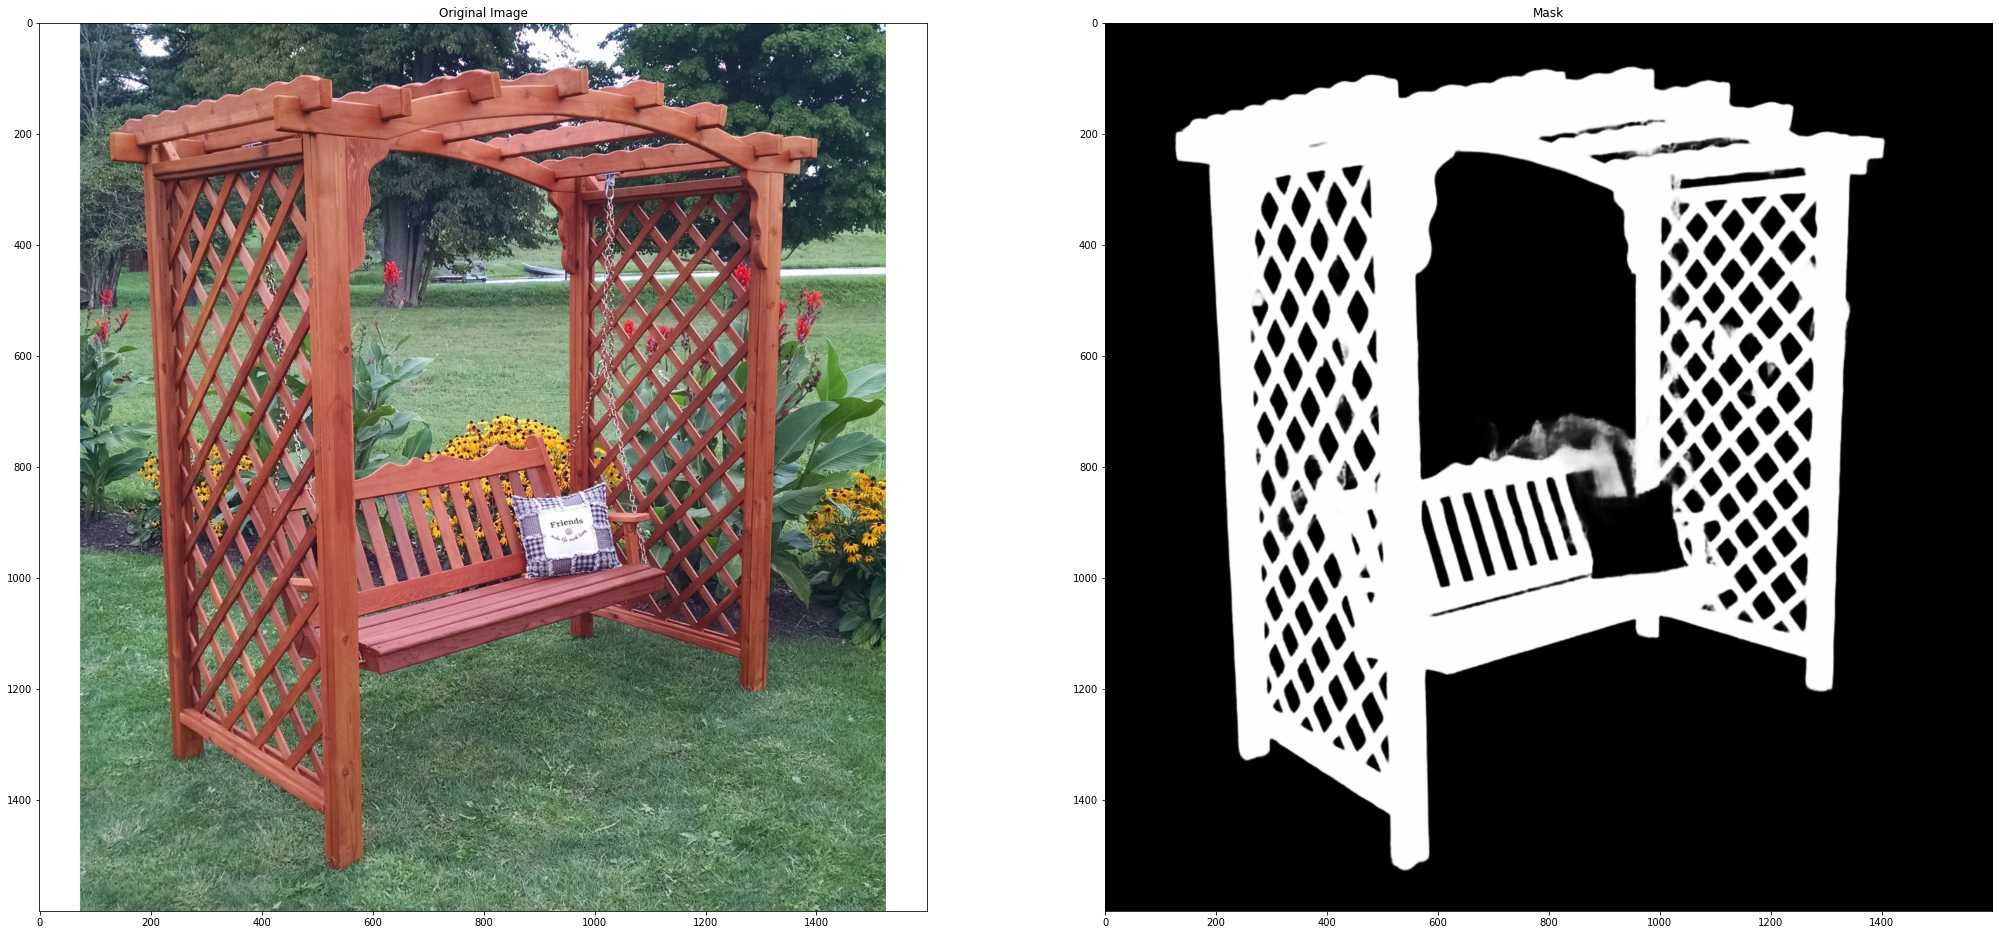

In [6]:
image_path = "https://i5.walmartimages.com/asr/43995148-22bf-4836-b6d3-e8f64a73be54.5398297e6f59fc510e0111bc6ff3a02a.jpeg"
image_bytes = BytesIO(requests.get(image_path).content)

image_tensor, orig_size = load_image(image_path, hypar) 
mask = predict(net,image_tensor,orig_size, hypar, device)

f, ax = plt.subplots(1,2, figsize = (35,20))

ax[0].imshow(np.array(Image.open(image_bytes))) # Original image
ax[1].imshow(mask, cmap = 'gray') # retouched image

ax[0].set_title("Original Image")
ax[1].set_title("Mask")

plt.show()